This is going to be the similar mass case with circular orbit and then implement Df equation with that


How this Jupyter Notebook will look like:
- Initialize the packets
- initial conditions
- dictate the circular orbit
- forloop
- effective energy plot (coming soon)

In [184]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import scipy as sci
from scipy import integrate
from scipy.integrate import odeint
from astropy import units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.constants as const
import math

In [185]:
plt.rcParams['font.family'] = 'Times New Roman'
#this is to make the font of the plots to be Times New Roman

In [186]:
const.G

<<class 'astropy.constants.codata2018.CODATA2018'> name='Gravitational constant' value=6.6743e-11 uncertainty=1.5e-15 unit='m3 / (kg s2)' reference='CODATA 2018'>

This is going to be the initial conditions

In [187]:
plt.rcParams['font.family'] = 'Times New Roman'
# region Code Snippet 1: IC's
G = const.G #change the innate time to years
m_gal = 1e11 * const.M_sun
#Masses
m1=4e8 * const.M_sun #mass of black hole A 
m2=4e8 * const.M_sun #mass of black hole B
# Will be adding the Standard Gravitational Parameter
#r_i has a separation of 430 pc
sep = 430*u.pc
r1_initial=[((sep/2.).value),0,0] * u.pc
r2_initial=[-((sep/2.).value),0,0] * u.pc
#To arrays
r1=np.array(r1_initial,dtype="float64") * u.pc
r2=np.array(r2_initial,dtype="float64") * u.pc

#Semi-major axis 
a = (0.5 * (sep))
print (a)

#COM
r_com=(m1*r1+m2*r2)/(m1+m2)

#orbital veloctiy
orb_v = (np.sqrt(const.G*(m1+m2)/a)).to(u.km/u.s) #added with Kris' source
print(orb_v)

#V_i
v1_initial=[0,(orb_v.value), 0] *u.km/u.s
v2_inital=[0,-(orb_v.value),0] *u.km/u.s #km/s

#To arrays
v1=np.array(v1_initial,dtype="float64") *u.km/u.s
v2=np.array(v2_inital,dtype="float64") *u.km/u.s
#Find velocity of COM
v_com=(m1*v1+m2*v2)/(m1+m2)

r = np.sqrt((r2[0] - r1[0])** 2 + (r2[1] - r1[1])** 2 + (r2[2] - r1[2])** 2)

# endregion

print(v1, v2)

215.0 pc
126.50459714101072 km / s
[  0.         126.50459714   0.        ] km / s [   0.         -126.50459714    0.        ] km / s


In [188]:
u.M_sun

Unit("solMass")

In [189]:
a_0 = 2.95 
b_0 = 0.596
mstar_tot = 1e11 * u.Msun
r_eff = (a_0*(mstar_tot/(1.e6*u.Msun))**b_0)* u.pc

print(r_eff)



2817.2281287632354 pc


In [190]:
m1 = 4e8 * u.Msun

rb = (m1/mstar_tot)**(1./3.)*r_eff
print("Binary radius is:", rb)
dyn_hard = ((rb/r_eff)**3*r_eff).to(u.pc)
print(dyn_hard)

Binary radius is: 447.20708952331626 pc
11.268912515052946 pc


Dynamical Friction and adding them as each component:

In [191]:
# region Code Snippet 2: DF
r1_com = r1 - r_com
r2_com = r2 - r_com

r1_com = np.sqrt(r1_com[0]**2 + r1_com[1]**2 + r1_com[2]**2) #we have to put the magnitude of the distance from each object from the COM
r2_com = np.sqrt(r2_com[0]**2 + r2_com[1]**2 + r2_com[2]**2)
 # region code : Semi Major Axes
#redacted the a becuase r = a in circular orbits
# rmax1 = np.max(r1 - r_com)
# rmin1 = np.min(r1 - r_com)
# a1 = (rmax1+rmin1)/2

# rmax2 = np.max(r2 - r_com)
# rmin2 = np.min(r2 - r_com)
# a2 = (rmax2+rmin2)/2
# endregion

o = ((10**(2.2969))*(m_gal/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
# region code : Coulomb Logarithm
x1 = (np.abs(r1_com.to(u.km)) * o**(2)) / (G * m1)
x2 = (np.abs(r2_com.to(u.km)) * o**(2)) / (G * m2)
ln_A1 = math.log10(x1.to_value(u.dimensionless_unscaled))
ln_A2 = math.log10(x2.to_value(u.dimensionless_unscaled))
# endregion

F_D1 = 0.428 * ln_A1 * ((G * m1**(2))/r1_com**(2))
F_D2 = 0.428 * ln_A2 * ((G * m2**(2))/r2_com**(2))

print(v1, v2)
v_r1 = v1 - v_com 
v_r2 = v2 - v_com
print(v_r1, v_r2)
v_rmag1 = np.sqrt(v_r1[0]**2 + v_r1[1]**2 + v_r1[2]**2)
v_rmag2 = np.sqrt(v_r2[0]**2 + v_r2[1]**2 + v_r2[2]**2)

print(v_rmag1, v_rmag2) 

v_rel_unit1 = (v_r1 / v_rmag1)
v_rel_unit2 = (v_r2 / v_rmag2)

print(v_rel_unit1, v_rel_unit2)



# region code: Dynamical Friction Component to Array for BH A
F_D1_i = (F_D1 * -v_rel_unit1[0])
F_D1_j = (F_D1 * -v_rel_unit1[1])
F_D1_k = (F_D1 * -v_rel_unit1[2])
    
F_D1 = np.array([F_D1_i.to((u.kg*u.m)/(u.s**2)).value, F_D1_j.to((u.kg*u.m)/ (u.s**2)).value, F_D1_k.to((u.kg*u.m)/ (u.s**2)).value])
# endregion

# region code: Dynamical Friction Component to Array for BH B
F_D2_i = (F_D2 * -v_rel_unit2[0])
F_D2_j = (F_D2 * -v_rel_unit2[1])
F_D2_k = (F_D2 * -v_rel_unit2[2])
    
F_D2 = np.array([F_D2_i.to((u.kg*u.m)/(u.s**2)).value, F_D2_j.to((u.kg*u.m)/ (u.s**2)).value, F_D2_k.to((u.kg*u.m)/ (u.s**2)).value])
# endregion


F_D1 = F_D1 * ((u.kg * u.m)/(u.s**2))
F_D2 = F_D2 * ((u.kg * u.m)/(u.s**2))
    

F_D1 = (F_D1 / m1).to(u.km / u.s**2)
F_D2 = (F_D2 / m2).to(u.km / u.s**2)




[  0.         126.50459714   0.        ] km / s [   0.         -126.50459714    0.        ] km / s
[  0.         126.50459714   0.        ] km / s [   0.         -126.50459714    0.        ] km / s
126.50459714101072 km / s 126.50459714101072 km / s
[0. 1. 0.] [ 0. -1.  0.]


In [192]:
m1 = 4e8 * u.Msun
m2 = 4e8 * u.Msun
massterm = (m1+m2)/(10**8*u.Msun)
velterm = ((200*u.km/u.s)/o)**2
dynhard_rad = (10*u.pc*massterm*velterm).to(u.pc)
print(dynhard_rad)



81.5361082035837 pc


In [193]:
coulomb_log_ = np.log10((a*o**2/(const.G*m1)).to(''))
print(coulomb_log_)
prefactor = 19./coulomb_log_
aterm = (a/(5.*u.kpc))**2
vterm = o/(200*u.km/u.s)
mterm = (10**8*u.Msun/(m1))
dyntime = (prefactor*aterm*vterm*mterm*u.Gyr).to(u.Myr)
print(dyntime)

0.6906173797913483
12.596880855045312 Myr


did all the checks that would dictate when they become a hard binary

In [194]:
T = dyntime
N = 5000
delta_t = T/ N


dv1bydt= ((G*m2*(r2-r1))/r**3).to(u.km / u.s**2) + F_D1
dv2bydt= ((-G*m1*(r2-r1))/r**3).to(u.km / u.s**2)  + F_D2
dr1bydt = v1  # maybe we don't need df subtraction here
dr2bydt = v2 
r_derivs=np.concatenate((dr1bydt.value,dr2bydt.value))
derivs=np.concatenate((r_derivs,dv1bydt.value,dv2bydt.value))

time_span=np.linspace(0, T, N) #Work on this with Kris' link

In [195]:
c = 1

[[ 1.34369870e+17 -7.08892329e+20 -0.00000000e+00]
 [ 2.68768826e+17 -7.08889501e+20 -0.00000000e+00]
 [ 4.03195836e+17 -7.08884696e+20 -0.00000000e+00]
 ...
 [ 1.14149564e+20  6.79263130e+20 -0.00000000e+00]
 [ 1.14116484e+20  6.79916286e+20 -0.00000000e+00]
 [ 1.14083280e+20  6.80570136e+20 -0.00000000e+00]] [[-1.34369870e+17  7.08892329e+20 -0.00000000e+00]
 [-2.68768826e+17  7.08889501e+20 -0.00000000e+00]
 [-4.03195836e+17  7.08884696e+20 -0.00000000e+00]
 ...
 [-1.14149564e+20 -6.79263130e+20 -0.00000000e+00]
 [-1.14116484e+20 -6.79916286e+20 -0.00000000e+00]
 [-1.14083280e+20 -6.80570136e+20 -0.00000000e+00]]


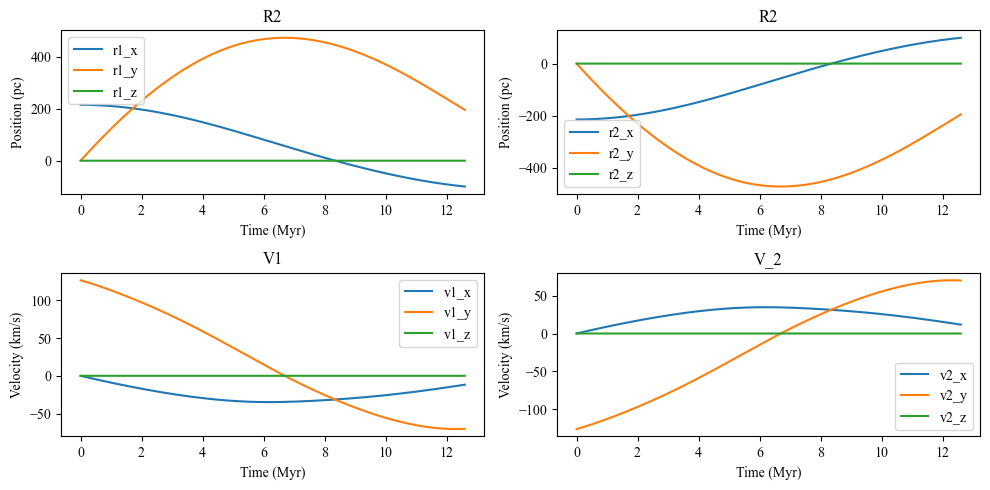

In [196]:
r1_sol = []
r2_sol = []
v1_sol = []
v2_sol = []
F_D1sol = []
F_D2sol = []


for i in range(N):
    dv1bydt=((G*m2*(r2-r1))/r**3).to(u.km / u.s**2) + (c * F_D1)
    dv2bydt=((-G*m1*(r2-r1))/r**3).to(u.km / u.s**2) + (c * F_D2) 
    v1 += dv1bydt * delta_t
    v2 += dv2bydt * delta_t

    r1 += v1.to(u.pc / u.s) * delta_t
    r2 += v2.to(u.pc / u.s) * delta_t
    # region Code Snippet 2: DF
    r1_com = r1 - r_com
    r2_com = r2 - r_com

    r1_com = np.sqrt(r1_com[0]**2 + r1_com[1]**2 + r1_com[2]**2) #we have to put the magnitude of the distance from each object from the COM
    r2_com = np.sqrt(r2_com[0]**2 + r2_com[1]**2 + r2_com[2]**2)
    # region code : Semi Major Axes
    #redacted the a becuase r = a in circular orbits
    # rmax1 = np.max(r1 - r_com)
    # rmin1 = np.min(r1 - r_com)
    # a1 = (rmax1+rmin1)/2

    # rmax2 = np.max(r2 - r_com)
    # rmin2 = np.min(r2 - r_com)
    # a2 = (rmax2+rmin2)/2
    # endregion

    o = ((10**(2.2969))*(m_gal/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
    # region code : Coulomb Logarithm
    x1 = (np.abs(r1_com.to(u.km)) * o**(2)) / (G * m1)
    x2 = (np.abs(r2_com.to(u.km)) * o**(2)) / (G * m2)
    ln_A1 = math.log10(x1.to_value(u.dimensionless_unscaled))
    ln_A2 = math.log10(x2.to_value(u.dimensionless_unscaled))
    # endregion

    F_D1 = 0.428 * ln_A1 * ((G * m1**(2))/r1_com**(2))
    F_D2 = 0.428 * ln_A2 * ((G * m2**(2))/r2_com**(2))


    v_r1 = v1 - v_com 
    v_r2 = v2 - v_com

    v_rmag1 = np.sqrt(v_r1[0]**2 + v_r1[1]**2 + v_r1[2]**2)
    v_rmag2 = np.sqrt(v_r2[0]**2 + v_r2[1]**2 + v_r2[2]**2) #will be doing this from now on though linalg.norm does the same

    v_rel_unit1 = (v_r1 / v_rmag1)
    v_rel_unit2 = (v_r2 / v_rmag2)

    # region code: Dynamical Friction Component to Array for BH A
    F_D1_i = (F_D1 * -v_rel_unit1[0])
    F_D1_j = (F_D1 * -v_rel_unit1[1])
    F_D1_k = (F_D1 * -v_rel_unit1[2])
        
    F_D1 = np.array([F_D1_i.to((u.kg*u.m)/(u.s**2)).value, F_D1_j.to((u.kg*u.m)/ (u.s**2)).value, F_D1_k.to((u.kg*u.m)/ (u.s**2)).value])
    # endregion

    # region code: Dynamical Friction Component to Array for BH B
    F_D2_i = (F_D2 * -v_rel_unit2[0])
    F_D2_j = (F_D2 * -v_rel_unit2[1])
    F_D2_k = (F_D2 * -v_rel_unit2[2])
        
    F_D2 = np.array([F_D2_i.to((u.kg*u.m)/(u.s**2)).value, F_D2_j.to((u.kg*u.m)/ (u.s**2)).value, F_D2_k.to((u.kg*u.m)/ (u.s**2)).value])
    # endregion


    F_D1 = F_D1 * ((u.kg * u.m)/(u.s**2))
    F_D2 = F_D2 * ((u.kg * u.m)/(u.s**2))
        

    F_D1 = (F_D1 / m1).to(u.km / u.s**2)
    F_D2 = (F_D2 / m2).to(u.km / u.s**2)
    F_D1sol.append([

        (F_D1_i.to((u.kg * u.m) / (u.s**2))/m1).value,
        (F_D1_j.to((u.kg * u.m) / (u.s**2))/m1).value,
        (F_D1_k.to((u.kg * u.m) / (u.s**2))/m1).value
    ])
    F_D2sol.append([

        (F_D2_i.to((u.kg * u.m) / (u.s**2))/m2).value,
        (F_D2_j.to((u.kg * u.m) / (u.s**2))/m2).value,
        (F_D2_k.to((u.kg * u.m) / (u.s**2))/m2).value
    ])




    r1_sol.append(r1.copy())
    r2_sol.append(r2.copy())
    v1_sol.append(v1.copy())
    v2_sol.append(v2.copy())


time_values = np.arange(0, N) * delta_t.to(u.Myr).value  # Convert delta_t to Myr or desired unit


r1_sol = np.array(r1_sol)  
r2_sol = np.array(r2_sol)  
v1_sol = np.array(v1_sol)  
v2_sol = np.array(v2_sol) 
F_D1sol = np.array(F_D1sol)
F_D2sol = np.array(F_D2sol)
print(F_D1sol, F_D2sol)




# region
fig, axs = plt.subplots(2, 2, figsize=(10, 5))


axs[0, 0].plot(time_values, r1_sol[:, 0], label="r1_x")
axs[0, 0].plot(time_values, r1_sol[:, 1], label="r1_y")
axs[0, 0].plot(time_values, r1_sol[:, 2], label="r1_z")
axs[0, 0].set_title("R2")
axs[0, 0].set_xlabel("Time (Myr)")
axs[0, 0].set_ylabel("Position (pc)")
axs[0, 0].legend()


axs[0, 1].plot(time_values, r2_sol[:, 0], label="r2_x")
axs[0, 1].plot(time_values, r2_sol[:, 1], label="r2_y")
axs[0, 1].plot(time_values, r2_sol[:, 2], label="r2_z")
axs[0, 1].set_title("R2")
axs[0, 1].set_xlabel("Time (Myr)")
axs[0, 1].set_ylabel("Position (pc)")
axs[0, 1].legend()


axs[1, 0].plot(time_values, v1_sol[:, 0], label="v1_x")
axs[1, 0].plot(time_values, v1_sol[:, 1], label="v1_y")
axs[1, 0].plot(time_values, v1_sol[:, 2], label="v1_z")
axs[1, 0].set_title("V1")
axs[1, 0].set_xlabel("Time (Myr)")
axs[1, 0].set_ylabel("Velocity (km/s)")
axs[1, 0].legend()


axs[1, 1].plot(time_values, v2_sol[:, 0], label="v2_x")
axs[1, 1].plot(time_values, v2_sol[:, 1], label="v2_y")
axs[1, 1].plot(time_values, v2_sol[:, 2], label="v2_z")
axs[1, 1].set_title("V_2")
axs[1, 1].set_xlabel("Time (Myr)")
axs[1, 1].set_ylabel("Velocity (km/s)")
axs[1, 1].legend()


plt.tight_layout()
plt.show()

# endregion
    


*mag of velocity + separation vector

In [197]:
r2_sol[-1]

array([  99.33445466, -195.45702144,    0.        ])

In [198]:
r1_sol[-1]

array([-99.33445466, 195.45702144,   0.        ])

In [199]:
finalsep = r2_sol[-1] - r1_sol[-1]
print(finalsep)

[ 198.66890932 -390.91404288    0.        ]


In [200]:
mag1 = np.linalg.norm(r1_sol[-1] - r2_sol[-1])



In [201]:
from scipy.signal import find_peaks
y_relative_to_center = v1_sol[:, 1]


peaks, _ = find_peaks(y_relative_to_center)

if len(peaks) >= 8:
    first_peak_time = time_span[peaks[0]]
    second_peak_time = time_span[peaks[1]]
    orbital_period = second_peak_time - first_peak_time
    orbital_period_years = orbital_period
    print(f"Simulated Orbital Period: {orbital_period_years:4f} years")


    plt.figure(figsize=(5, 3))
    plt.plot(time_span, y_relative_to_center, label='Y relative to center', color='purple')
    plt.scatter(time_span[peaks], y_relative_to_center[peaks], color='black', label='Peaks')
    plt.xlabel('Time (Gyr)')
    plt.ylabel('Velocity (y-direction) (km/s)')
    plt.title('Orbital Period Detection')
    plt.grid(True)
    plt.legend(loc = "upper right")
    plt.show()
else:
    print("Could not find two peaks to determine the orbital period.")


Could not find two peaks to determine the orbital period.


In [202]:
# F_D1_magnitude = np.sqrt(F_D1sol[0]**2 + F_D1sol[1]**2 + F_D1sol[2]**2)
# F_D2_magnitude = np.sqrt(F_D2sol[0]**2 + F_D2sol[1]**2 + F_D2sol[2]**2)

# plt.figure(figsize=(10, 6))
# plt.plot(time_values, F_D1_magnitude, label='Magnitude of DF for BH A', color='blue')
# plt.plot(time_values, (0.1 * F_D1_magnitude), label='0.1x DF', color='red')
# plt.plot(time_values, (10 * F_D1_magnitude), label='10x DF', color='orange')
# # plt.plot(time_values, (100 * F_D1_magnitude), label='100x DF', color='green')

# plt.xlabel('Time (Myr)')
# plt.ylabel('Magnitude of Dynamical Friction (km/s²)')
# plt.title('Changes of Dynamical Friction through Time')
# plt.legend()
# plt.grid(True)
# plt.show()

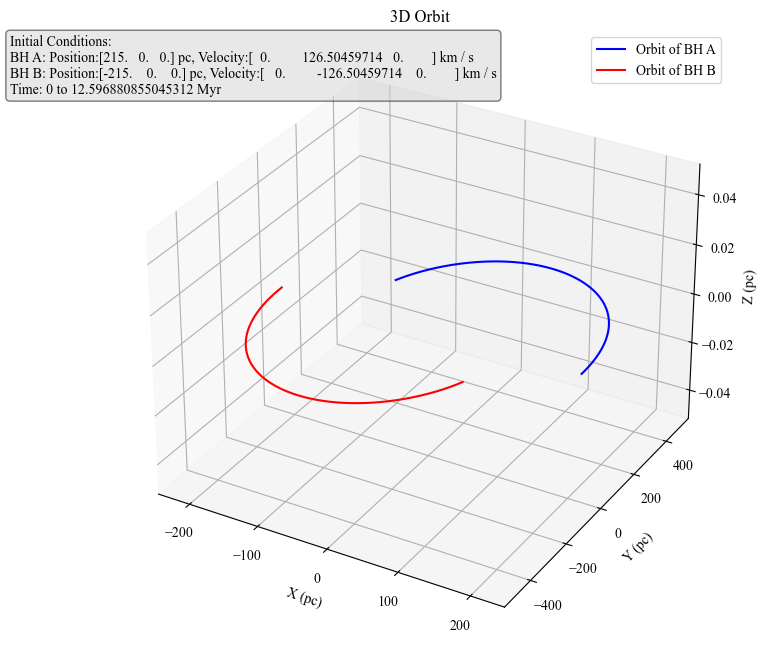

In [203]:
from mpl_toolkits.mplot3d import Axes3D  


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


ax.plot(r1_sol[:, 0], r1_sol[:, 1], r1_sol[:, 2], label="Orbit of BH A", color="blue")


ax.plot(r2_sol[:, 0], r2_sol[:, 1], r2_sol[:, 2], label="Orbit of BH B", color="red")


ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)') 
ax.set_zlabel('Z (pc)')
ax.set_title('3D Orbit')


ax.legend()

initial_conditions_text = (
    f"Initial Conditions:\n"
    f"BH A: Position:{r1_initial}, Velocity:{v1_initial}\n"
    f"BH B: Position:{r2_initial}, Velocity:{v2_inital}\n"
    f"Time: 0 to {T}"
)
fig.text(0, 0.8, initial_conditions_text, fontsize=10, bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.5))

plt.show()

/var/folders/rf/799sdl_537nf32dnhw741jq80000gn/T/ipykernel_86876/2219407164.py:24: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_zlim([min(np.min(r1_sol[:, 2]), np.min(r2_sol[:, 2])), max(np.max(r1_sol[:, 2]), np.max(r2_sol[:, 2]))])


Text(0, 0.8, 'Initial Conditions:\nBH A: Position:[215.   0.   0.] pc, Velocity:[  0.         126.50459714   0.        ] km / s\nBH B: Position:[-215.    0.    0.] pc, Velocity:[   0.         -126.50459714    0.        ] km / s\nTime: 0 to 12.596880855045312 Myr')

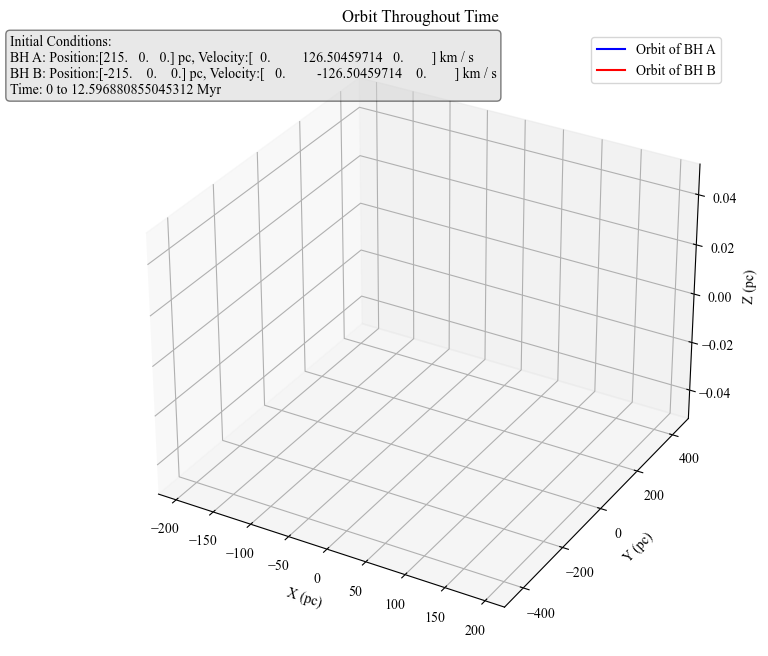

In [204]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')
ax.set_title('Orbit Throughout Time')


line1, = ax.plot([], [], [], label="Orbit of BH A", color="blue")
line2, = ax.plot([], [], [], label="Orbit of BH B", color="red")
ax.legend()

# Limits for the plot (adjust as needed based on data)
ax.set_xlim([min(np.min(r1_sol[:, 0]), np.min(r2_sol[:, 0])), max(np.max(r1_sol[:, 0]), np.max(r2_sol[:, 0]))])
ax.set_ylim([min(np.min(r1_sol[:, 1]), np.min(r2_sol[:, 1])), max(np.max(r1_sol[:, 1]), np.max(r2_sol[:, 1]))])
ax.set_zlim([min(np.min(r1_sol[:, 2]), np.min(r2_sol[:, 2])), max(np.max(r1_sol[:, 2]), np.max(r2_sol[:, 2]))])


def update(num):

    line1.set_data(r1_sol[:num, 0], r1_sol[:num, 1])
    line1.set_3d_properties(r1_sol[:num, 2])
    
    line2.set_data(r2_sol[:num, 0], r2_sol[:num, 1])
    line2.set_3d_properties(r2_sol[:num, 2])
    
    return line1, line2

initial_conditions_text = (
    f"Initial Conditions:\n"
    f"BH A: Position:{r1_initial}, Velocity:{v1_initial}\n"
    f"BH B: Position:{r2_initial}, Velocity:{v2_inital}\n"
    f"Time: 0 to {T}"
)
fig.text(0, 0.8, initial_conditions_text, fontsize=10, bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.5))

# ani = FuncAnimation(fig, update, frames=len(r1_sol), interval=50, blit=True)


# plt.show()


# ani.save("J1010#5.mp4", writer="ffmpeg", fps=220)  # Adjust fps as needed

Plot of Velocities